In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
#There are many geocoding services available, but Nominatim does not require an API key to access.
from geopy.geocoders import Nominatim
import folium #Interracting map
from matplotlib import pyplot

## Data Exploration
- Let's extract the data first and concat the two json file into single csv file. Save the csv file
- Data exploration afterwards

In [2]:
# df = pd.read_json('gumtree.json')
# df2 = pd.read_json('remaininggumtree.json')
# data = pd.concat([df,df2])
# #Saving it as a final_data.csv
# data.to_csv('final_data.csv',index=False)

In [3]:
dataset = pd.read_csv('finals.csv')

In [4]:
#Let's check out the coloumn names
dataset.columns #All the coloumns here are important so we won't be deleting it. 

Index(['Unnamed: 0', 'Year', 'Body type', 'Mileage', 'Transmission',
       'Brochure Engine size', 'Fuel type', 'Urban mpg', 'Extra Urban mpg',
       'Fuel Consumption', 'Insurance Group', 'CO2 emissions',
       'Euro Emissions', 'Engine Power', 'Engine size',
       'Acceleration (0-62mph)', 'Top Speed', 'Seats', 'Doors', 'Colour',
       'Fuel Capacity', 'Luggage Capacity (seats up)', 'Price', 'Name',
       'Location'],
      dtype='object')

In [5]:
#However some of the coloumns needs some renaming to be done 
#The reason we are doing this is because we want
dataset.rename({'Acceleration (0-62mph)':'Acceleration(0-62mph)','Luggage Capacity (seats up)':'Luggage Capacity(seats_up)'},inplace=True)

In [6]:
#Checking if there is any duplicate values in the dataset
#Let's find out duplicate values
dataset.duplicated().sum() #There are alltogether 300 values that are duplicate
#Let's see what those duplicate values are
duplicates = dataset[dataset.duplicated()]
#duplicates.to_csv('duplicates.csv',index=False) #Exporting to csv to further analyse the data properly.(Not necessary)

In [7]:
#Let's remove the duplciates from the main dataset
final_dataset = dataset.drop_duplicates()

In [8]:
#Let's work with the dataset now that the duplicates has been removed. 
#We see alot of blank data so let's replace the blank data points with NaN
final_dataset = final_dataset.replace(r'^\s*$',np.nan,regex = True) #Using regex

#Let's also remove unwanted spaces from the string coloumn name
final_dataset['Name'] = final_dataset['Name'].str.strip()

In [9]:
#final_dataset.to_csv('finals.csv',index=False) #We sucessfully removed all the 300 duplicates from the data. 
#Before the data dimanesion was 1078 rows × 24 columns and now after removing 300 duplicate values, it is 778 rows × 24 columns

In [10]:
#Let's remove the unwanted columns
final_dataset.drop(['Urban mpg','Extra Urban mpg','Luggage Capacity (seats up)',],axis=1,inplace=True)

In [11]:
#Let's clean coloumns that needs cleaning
def remove_html_tags(string):
    result = re.sub('</h1','',string)
    return result

def remove_emojis(col): #Upon careful looking at the dataset carefully, there is an emoji '💥' that is in dataset s
    col = col.apply(lambda x: x.encode('ascii','ignore').decode('ascii')) #let's remove it. 
    return col

final_dataset['Name'] = final_dataset['Name'].apply(lambda x : remove_html_tags(x))
final_dataset['Name'] = remove_emojis(final_dataset['Name']) 

In [12]:
#Let's check oout empty coloumns
final_dataset.isna().sum()

#Looks like there are alot of missing values that we need to handle. The coloumns with missing values are
#Brochure Engine Size
#Urban mpg
#Extra Urban mpg
#Insurance group
#C02 emissions
#Euro Emissions
#Engine Power
#Acceleration
#Top Speed
#Seats
#Doors
#Fuel Capacity
#Luggage Capacity
#Let's work on the missing values one by one. The good thing about missing values in car is that you can simply manually google it

Unnamed: 0                 0
Year                       0
Body type                  0
Mileage                    0
Transmission               0
Brochure Engine size       4
Fuel type                  0
Fuel Consumption           8
Insurance Group           16
CO2 emissions              1
Euro Emissions             4
Engine Power               1
Engine size                0
Acceleration (0-62mph)    13
Top Speed                  1
Seats                      1
Doors                      3
Colour                     0
Fuel Capacity             39
Price                      0
Name                       0
Location                   0
dtype: int64

In [ ]:
#Let's seperate the dataset by creating a different variable for only the empty borchure size
empty_brochure = final_dataset[final_dataset['Brochure Engine size'].isna()] 

#Let's remove the nan file with the one we googled.
empty_brochure['Brochure Engine size'][empty_brochure.Name=='Toyota Hilux 3.0l Invincible'] = '3.0L' #For the Toyota
empty_brochure['Brochure Engine size'][empty_brochure.Name=='2011 Volkswagen Golf Match TDI 1.6 105 PS Hatchback Diesel Manual'] = '1.6L' #For volkswagen hatchback
empty_brochure['Brochure Engine size'][empty_brochure.Name=='2021 Citroen C4 50kWh Shine Plus Auto 5dr Hatchback Electric Automatic'] = 'Electric engine' #For Citroen C4
empty_brochure['Brochure Engine size'][empty_brochure.Name=='2021 Nissan Navara Brand new 2121 model  Double Cab Pick Up N-Guard in stock  wi'] = '2.3L' #For volkswagen hatchback

#Merge the final dataset with updated empty brochure updated data
final_dataset.update(empty_brochure) #It has been updated

In [ ]:
#Let's work on fuel consumption empty data and turning it into dictionary
fuel_consumption = final_dataset[final_dataset['Fuel Consumption'].isna()] 

name = list(fuel_consumption['Name'])
consumption = ['62.8mpg','0mpg','0mpg','0mpg','0mpg','60mpg','0.0mpg','65.7mpg'] #Co
consumption_dict = dict(zip(name,consumption))

for i,j in consumption_dict.items():
    fuel_consumption['Fuel Consumption'][fuel_consumption.Name=='{}'.format(i)] = '{}'.format(j)

final_dataset.update(fuel_consumption) #Updating the final dataframe

In [ ]:
#Since there is only one missing value for CO2 emissions, let's use the normal way to fill in the data
CO2_emission = final_dataset[final_dataset['CO2 emissions'].isna()] 

#CO2 emission filling
CO2_emission['CO2 emissions'][CO2_emission.Name=='2011 Volkswagen Golf Match TDI 1.6 105 PS Hatchback Diesel Manual'] = '119g/km'

final_dataset.update(CO2_emission) #Updating the final dataframe

In [ ]:
#Let's work on the missing Euro Emissions
euro_emission = final_dataset[final_dataset['Euro Emissions'].isna()] 
car_name = list(euro_emission['Name'])
euro_missing = ['Euro 3','Euro 5','Euro 3','Euro 2']

#Converting it into dictionary
euro_dict = dict(zip(car_name,euro_missing))

#Filling the data
for i,j in euro_dict.items():
    euro_emission['Euro Emissions'][euro_emission.Name=='{}'.format(i)] = '{}'.format(j)
    
final_dataset.update(euro_emission)

In [ ]:
engine_power = final_dataset[final_dataset['Engine Power'].isna()] 
engine_power['Engine Power'][engine_power.Name=='2011 Volkswagen Golf Match TDI 1.6 105 PS Hatchback Diesel Manual'] = '103.3bhp'
final_dataset.update(engine_power) 

In [ ]:
top_speed = final_dataset[final_dataset['Top Speed'].isna()] 
top_speed['Top Speed'][top_speed.Name=='2011 Volkswagen Golf Match TDI 1.6 105 PS Hatchback Diesel Manual'] = '117mph'
final_dataset.update(top_speed) 

In [ ]:
#For seats
seats = final_dataset[final_dataset['Seats'].isna()] 
seats['Seats'][seats.Name=='2011 Volkswagen Golf Match TDI 1.6 105 PS Hatchback Diesel Manual'] = '5'
final_dataset.update(seats) 

In [ ]:
#For doors
doors = final_dataset[final_dataset['Doors'].isna()] 
doorcar_name = list(doors['Name'])
doors_missing = ['5','5','5']
seat_dict = dict(zip(doorcar_name,doors_missing))

for i,j in seat_dict.items():
    doors['Doors'][doors.Name=='{}'.format(i)] = '{}'.format(j)
    
final_dataset.update(doors)


In [ ]:
#Let's work for the acceleration
acceleration = final_dataset[final_dataset['Acceleration (0-62mph)'].isna()]
acceleration_name = list(acceleration['Name'])
acceleration_missing = ['11.0seconds','7.5seconds','5.9seconds','9.3seconds','5.5seconds',
                        '9.2seconds','7.5seconds','11.8seconds','9.7seconds','17.3seconds','7seconds',
                        '12seconds','10.7seconds']
acceleration_dict = dict(zip(acceleration_name,acceleration_missing))
for i,j in acceleration_dict.items():
    acceleration['Acceleration (0-62mph)'][acceleration.Name=='{}'.format(i)] = '{}'.format(j)
    
final_dataset.update(acceleration)

In [22]:
#Let's work on the insurance group. Let's just add the string 'unknown' to the missing value in insurance coloumn
final_dataset['Insurance Group'] = final_dataset['Insurance Group'].fillna('Unknown')

In [ ]:
#Let's now work on the empty value of Fuel Capacity
fuel_capacity = final_dataset[final_dataset['Fuel Capacity'].isna()]
fuel_car_name = list(fuel_capacity['Name'])
fuel_capacity_missing = ['50litres','61litres','97litres','62litres','42litres','60litres','55litres','53litres','65litres',
                        '62litres','42litres','60litres','0litres','54litres','0litres','60litres','54litres','64litres',
                        '42litres','40litres','53litres','42litres','50litres','45litres','50litres','40litres','40litres',
                        '0litres','0litres','56litres','65litres','43litres','87litres','0litres','63litres','53.5litres',
                        '50litres','43litres','88litres','28litres']
fuel_capacity_dict = dict(zip(fuel_car_name,fuel_capacity_missing))
for i,j in fuel_capacity_dict.items():
    fuel_capacity['Fuel Capacity'][fuel_capacity.Name=='{}'.format(i)] = '{}'.format(j)
    
final_dataset.update(fuel_capacity)

In [24]:
final_dataset.drop(['Unnamed: 0'],axis=1,inplace=True)

In [25]:
final_dataset.columns

Index(['Year', 'Body type', 'Mileage', 'Transmission', 'Brochure Engine size',
       'Fuel type', 'Fuel Consumption', 'Insurance Group', 'CO2 emissions',
       'Euro Emissions', 'Engine Power', 'Engine size',
       'Acceleration (0-62mph)', 'Top Speed', 'Seats', 'Doors', 'Colour',
       'Fuel Capacity', 'Price', 'Name', 'Location'],
      dtype='object')

In [26]:
#Let's map out the location in the actual maps
geolocator = Nominatim(timeout = 10,user_agent = 'myGeoLocator') #Check out nominatim documentation

In [27]:
final_dataset['geocode'] = final_dataset.Location.apply(geolocator.geocode) #Converts data into location 

In [28]:
final_dataset['latitude'] = [0 if x is None else x.latitude for x in final_dataset.geocode] #If it can't find the latitude, leave it empty
final_dataset['longitude'] = [0 if x is None else x.longitude for x in final_dataset.geocode]#If it can't find the longitude, leave it empty

In [30]:
#Now that we have latitude and longitude, we can plot the addresses using Folium, a python library for making interactive maps.
#This is to create an empty ma
my_map = folium.Map(location=[51.5074, 0.1278],zoom_start = 13) #UK coordinates
display(my_map)

In [33]:
for index, row in final_dataset.iterrows():
    folium.Marker(location=(row['latitude'],row['longitude'])).add_to(my_map)
display(my_map)

In [32]:
final_dataset

Index(['Year', 'Body type', 'Mileage', 'Transmission', 'Brochure Engine size',
       'Fuel type', 'Fuel Consumption', 'Insurance Group', 'CO2 emissions',
       'Euro Emissions', 'Engine Power', 'Engine size',
       'Acceleration (0-62mph)', 'Top Speed', 'Seats', 'Doors', 'Colour',
       'Fuel Capacity', 'Price', 'Name', 'Location', 'geocode', 'latitude',
       'longitude'],
      dtype='object')

In [39]:
total_inlocation = final_dataset['Location'].value_counts()

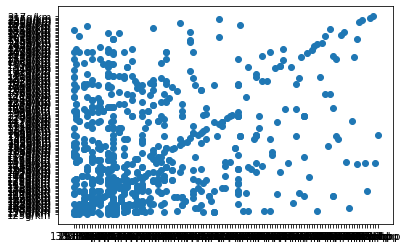

In [54]:
#Let's check some correlation with engine power and engine size
pyplot.scatter(final_dataset['Engine Power'],final_dataset['CO2 emissions'])

In [ ]:
#Brochure engine size
#Before googling the data, we need to check which rows of brochure engine size datas are missing from and which car it belongs to
# The four missing values for borchure are 
#2008 Toyota Hilux 3.0l Invincible ---> 3.0L
#2011 Volkswagen golf match TDI 1.6 105 PS HatchBack -->1.6L
#2021 Citroen C4 50kWh Shine Plus Auto 5dr HatchBack --Electric
#2021 Nissan Navara Brand new 2121 model Double hatchback-->2.3L

#Looks like some of the empty brochure size is of that of electric cars, so let's clean that aswell